# Model Building
This notebook has two sections:
1. data engineering to prepare data to be model-ready
2. machine learning to discover intrinsic correlation between certain disease and behaviors'

Here I still use the 2015 Behavior Risk Factor Surveillance System data for the analysis.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
# from sklearn.impute import SimpleImputer
from scipy import stats
plt.style.use('ggplot')

In [30]:
path = "C:/Users/yao_p/Downloads/behavioral-risk-factor-surveillance-system/2015.csv"
df = pd.read_csv(path)

In this notebook, I am trying to answer the following questions:
+ *__how do behaviors affect mental health (depressive disorder)?__*

Among all features provided in the dataset, the following are of great importance for my purpose:
+ __behavior features__

    _INCOMG. _Composite income category_

    MARITAL. _Marriage status_

    _AGEG5YR. _Age group_

    EDUCA. _Education level_

    _PA150R2. _150 min physcial activity category (whether a person get at least 150 min of exercise per week)_

    _PA300R2. _300 min physical activity category (whether a person get at least 300 min of exercise per week)_
        
    _PAREC1. _Aerobic and strenghtening guideline (whether a person meet the aerobic and strenghtening guideline)_

    _RFBING5. _Binge driver category_

    _RFSMOK3. _Smoking category_
    
    _BMI5CAT. _BMI category_


+ __illness features__
    
    ADDEPEV2. _Ever been told had depressive disorder?_ 
    
    DIABETE3. _Ever been told had diabetes?_
    
    CHCKIDNY. _Ever been told had kidney cancer?_
    
    CHCSCNCR. _Ever been told had skin cancer?_
    
    CHCOCNCR. _Ever been told had other cancer?_

All behavior features are categorical data, there is no continous data involved in the feature.

The goal is to use behavoir features to predict diseases. Even though some disease might have more than 2 categories, such as diabetes could be yes, no and boarderline diabetes, for simplicity all diseases only have two status: yes or no. Therefore the problem boils down to a binary category problem.

In [31]:
bh_factor = ['_INCOMG','MARITAL','_AGEG5YR','EDUCA','_PA150R2','_PA300R2','_PAREC1','_RFBING5','_RFSMOK3','_BMI5CAT']
illness = ['ADDEPEV2','DIABETE3','CHCKIDNY','CHCSCNCR','CHCOCNCR']

df_bh = df[bh_factor+illness]

From the last notebook (EDA), we know that:
1. for many features, categories 7 and 9 mean the respondent refused to answer the question/ didn't knonw the answer to the question. Therefore it should be set as None.

2. some features use category 14 to mean the respondent refused to answer the question/ didn't knonw the answer to the question. Therefore it should be set as None.

3. for diabete feature(DIABETE3), categories 2,3,4 mean 'yes, but female during pregnancy', 'no', 'no, pre- or border-diabetes'. For simplicity, 2 is re-assigned to as 'yes' (1), and 3 and 4 are re-assigned to as 'no' (2)

After data clean, we can drop all null values since in general those values are only a small portion of the dataset.

In [33]:
df_bh['_INCOMG'].replace(to_replace=9, value=np.nan, inplace=True)
df_bh['MARITAL'].replace(to_replace=9, value=np.nan, inplace=True)
df_bh['_AGEG5YR'].replace(to_replace=14, value=np.nan, inplace=True)
df_bh['EDUCA'].replace(to_replace=9, value=np.nan, inplace=True)
df_bh['_PA150R2'].replace(to_replace=9, value=np.nan, inplace=True)
df_bh['_PA300R2'].replace(to_replace=9, value=np.nan, inplace=True)
df_bh['_PAREC1'].replace(to_replace=9, value=np.nan, inplace=True)
df_bh['_RFBING5'].replace(to_replace=9, value=np.nan, inplace=True)
df_bh['_RFSMOK3'].replace(to_replace=9, value=np.nan, inplace=True)
df_bh['_BMI5CAT'].replace(to_replace=5, value=np.nan, inplace=True)

df_bh['ADDEPEV2'].replace(to_replace=7, value=np.nan, inplace=True)
df_bh['ADDEPEV2'].replace(to_replace=9, value=np.nan, inplace=True)

df_bh['DIABETE3'].replace(to_replace=7, value=np.nan, inplace=True)
df_bh['DIABETE3'].replace(to_replace=9, value=np.nan, inplace=True)
df_bh['DIABETE3'].replace(to_replace=2, value=1, inplace=True)
df_bh['DIABETE3'].replace(to_replace=3, value=2, inplace=True)
df_bh['DIABETE3'].replace(to_replace=4, value=2, inplace=True)

df_bh['CHCKIDNY'].replace(to_replace=7, value=np.nan, inplace=True)
df_bh['CHCKIDNY'].replace(to_replace=9, value=np.nan, inplace=True)

df_bh['CHCSCNCR'].replace(to_replace=7, value=np.nan, inplace=True)
df_bh['CHCSCNCR'].replace(to_replace=9, value=np.nan, inplace=True)

df_bh['CHCOCNCR'].replace(to_replace=7, value=np.nan, inplace=True)
df_bh['CHCOCNCR'].replace(to_replace=9, value=np.nan, inplace=True)

df_bh.dropna(inplace=True)
df_bh.reset_index(drop=True, inplace=True)

C:\Users\yao_p\Anaconda3\lib\site-packages\pandas\core\generic.py:5886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\yao_p\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


To better understand each feature, all the numerical codes are changed to phases

In [34]:
df_bh.columns = ['income',
                'marriage_status',
                'age_cat',
                'edu',
                'exercise_cat150', 
                'exercise_cat300',
                'exercise_guide',
                'binge',
                'smoke',
                'bmi_cat',
                'depress_disorder',
                'diabetes',
                'kidney',
                'skin_cancer',
                'other_cancer',
                ]

income_dict = {1:'<15,000',
              2:'>15,000 and < 25,000',
              3:'>25,000 and < 35,000',
              4:'>35,000 and <50,000',
              5:'>50,000',
              9:"don't know/not sure/missing"}

smoke_dict = {1:'no',
             2:'yes',
             9:"don't know/refused/missing"}

binge_dict = {1:'no',
             2:'yes',
             9:"don't know/refused/missing"}

m150_dict = {1:'more than 150 min',
            2:'less than 150 min',
            3:'0 min',
            9:"don't know/not sure/refused/missing"}

m300_dict = {1:'more than 300 min',
            2:'less than 300 min',
            3:'0 min',
            9:"don't know/not sure/refused/missing"}

guide_dict = {1:'meet both',
            2:'meet aerobic guideline only',
            3:'meet strengthening guideline only',
            4:'meet neigher',
            9:"don't know/not sure/refused/missing"}

bmi_dict = {1:'underweight',
           2:'normal weight',
           3:'overweight',
           4:'obese',
           5:"don't know/refused/missing"}

marr_dict = {1:'married',
            2:'divorced',
            3:'widowed',
            4:'separated',
            5:'never married',
            6:'member of an unmarried couple',
            9:'refused'}

age_dict = {1:'18-24',
           2:'25-29',
           3:'30-34',
           4:'35-39',
           5:'40-44',
           6:'45-49',
           7:'50-54',
           8:'55-59',
           9:'60-64',
           10:'65-69',
           11:'70-74',
           12:'75-79',
           13:'80 and above',
           14:"don't know/refused/missing"}

edu_dict = {1:'never', 
            2:'elementary', 
            3:'some high school', 
            4:'high school grad', 
            5:'some college', 
            6:"college grad", 
            9:'refused'}

depress_dict = {1:'yes',
               2:'no',
               7:"don't know/not sure",
               9:'refused'}

diab_dict = {1:'yes',
            2:'yes, but female during pregnancy',
            3:'no',
            4:'no, pre- or border-diabetes',
            7:"don't know/not sure",
            9:'refused'}

kidney_dict = {1:'yes',
               2:'no',
               7:"don't know/not sure",
               9:'refused'}

skin_dict = {1:'yes',
            2:'no',
            7:"don't know",
            9:'refused'}

other_cancer_dict = {1:'yes',
            2:'no',
            7:"don't know",
            9:'refused'}

In [14]:
def change_label(series, dictionary):
    temp = [dictionary[val] for val in series]
    return pd.Series(temp)

In [15]:
df_bh['income'].update(change_label(df_bh['income'], income_dict))
df_bh['marriage_status'].update(change_label(df_bh['marriage_status'], marr_dict))
df_bh['age_cat'].update(change_label(df_bh['age_cat'], age_dict))
df_bh['edu'].update(change_label(df_bh['edu'], edu_dict))
df_bh['exercise_cat150'].update(change_label(df_bh['exercise_cat150'], m150_dict))
df_bh['exercise_cat300'].update(change_label(df_bh['exercise_cat300'], m300_dict))
df_bh['exercise_guide'].update(change_label(df_bh['exercise_guide'], guide_dict))
df_bh['binge'].update(change_label(df_bh['binge'], binge_dict))
df_bh['smoke'].update(change_label(df_bh['smoke'], smoke_dict))
df_bh['bmi_cat'].update(change_label(df_bh['bmi_cat'], bmi_dict))
df_bh['depress_disorder'].update(change_label(df_bh['depress_disorder'], depress_dict))
df_bh['diabetes'].update(change_label(df_bh['diabetes'], diab_dict))
df_bh['kidney'].update(change_label(df_bh['kidney'], kidney_dict))
df_bh['skin_cancer'].update(change_label(df_bh['skin_cancer'], skin_dict))
df_bh['other_cancer'].update(change_label(df_bh['other_cancer'], other_cancer_dict))

C:\Users\yao_p\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\yao_p\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\yao_p\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(c

In [36]:
df_bh.to_csv('cat_behavior_vs_depressive_discorder.csv', index=False)

## Use Multiple classifier to predict despressive disorder from behaviors 

In [17]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.utils import resample


# from google.colab import drive
# drive.mount('/content/gdrive')

# from google.colab import files
# files.upload('C:\Users\ypeng\')

In [37]:
read_from_file = True
if read_from_file:
#     path = '/content/gdrive/My Drive/cat_behavior_vs_depressive_discorder.csv'
    path = 'cat_behavior_vs_depressive_discorder.csv'
    df_bh = pd.read_csv(path)
else:
    pass

Pick only one disease each time for model training and testing.

from EDA, it is easy to see that the majority of respondents do not have a certain disease. Therefore training on the raw data will lead to the data unbalance issue. For instance, for a disease with 90% people free of it, ML models are likely to treat the remaining 10% people who have the disease as noise and therefore are ignored.

In this project, both minority upsampling and majority downsampling methods are used to achieve a balance dataset. After data engineering, the number of 'yes' and 'no' are the same in the dataset.

In [39]:
disease_label = ['diabetes']
disease_labels = ['depress_disorder','diabetes','kidney','skin_cancer','other_cancer']
# behavior_labels = ['income','exercise_cat150','exercise_cat300','exercise_guide','bmi_cat']
disease_labels.remove(disease_label[0])
X = df_bh.drop(columns=disease_labels)
# X = df_bh[df_bh['age_cat']>=8]
# X = X[behavior_labels+disease_label]

temp = X[disease_label[0]].value_counts()
X_majority = X[X[disease_label[0]]==2]
X_minority = X[X[disease_label[0]]==1]

# upsample minority label or downsample majority label
upsampled = True
if upsampled:
    X_minority_upsampled = resample(X_minority,
                                    replace=True,
                                    n_samples=temp.values[0],
                                    random_state=12)
    X_upsampled = pd.concat([X_majority, X_minority_upsampled])
    X_upsampled = shuffle(X_upsampled)
    y = X_upsampled[disease_label[0]]
    X = X_upsampled.drop(columns=disease_label)
else:
    X_majority_downsampled = resample(X_majority,
                                    replace=False,
                                    n_samples=temp.values[1],
                                    random_state=12)
    X_downsampled = pd.concat([X_minority, X_majority_downsampled])
    X_downsampled = shuffle(X_downsampled)
    y = X_downsampled[disease_label[0]]
    X = X_downsampled.drop(columns=disease_label)

y[y==2.0] = 0
# y[y==1.0] = True
for column in list(X.columns):
    X[column] = X[column].astype('category')
X = pd.get_dummies(X)
print('size of X is: {}'.format(X.shape))



size of X is: (519014, 48)


Multiple classifiers were originally chosen to compare different model behaviors. Models include:
+ Logistic Regression
+ Gussian Naive Bayes
+ Support Vector Machine

Also ensemble methods include:
+ Gradient Boosting
+ Adaptive Boosting
+ Random Forest
+ Voting method 

Deep Nerual Network (DNN) is also used for this classification problem.

After model testing, it is concluded that ensemble models in general behave better that single classifiers. Therefore for the rest of model training and testing, I only focus on the ensemble methods.

It should be noted that for the purpose of of this project, that is, identify individuals that could have a higher chance of getting certain illness, recall is a better metric for acuracy. Therefore recall is used.

In [0]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=21)
# LR = LogisticRegression()
# NB = GaussianNB()
# SVC = SVC(probability=True)


GB = GradientBoostingClassifier(max_depth=5, n_estimators=200, max_features='auto', verbose=1)
AB = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=500)
RF = RandomForestClassifier(max_depth=10, n_estimators=500, verbose=1, n_jobs=-1)
VC = VotingClassifier(estimators=[('RF',RF),('GB',GB),('AB',AB)], voting='soft', n_jobs=-1)


In [0]:
# individual classifier
# LR.fit(Xtrain, ytrain)
# NB.fit(Xtrain, ytrain)
# SVC.fit(Xtrain, ytrain)

# ensemble classifier
RF.fit(Xtrain, ytrain)
AB.fit(Xtrain, ytrain)
GB.fit(Xtrain, ytrain)
VC.fit(Xtrain, ytrain)


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   58.8s finished


      Iter       Train Loss   Remaining Time 
         1           1.3621            4.90m
         2           1.3424            5.38m
         3           1.3271            5.56m
         4           1.3150            5.32m
         5           1.3028            5.40m
         6           1.2926            5.39m
         7           1.2835            5.56m
         8           1.2758            5.54m
         9           1.2690            5.46m
        10           1.2635            5.36m
        20           1.2298            4.92m
        30           1.2166            4.53m
        40           1.2098            4.21m
        50           1.2055            3.92m
        60           1.2026            3.60m
        70           1.2004            3.29m
        80           1.1986            3.00m
        90           1.1969            2.73m
       100           1.1955            2.45m
       200           1.1842            0.00s


VotingClassifier(estimators=[('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig...e,
            splitter='best'),
          learning_rate=1.0, n_estimators=500, random_state=None))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [0]:
ypred = RF.predict(Xtrain)
print('random forest recall score (train case): {}'.format(recall_score(ytrain, ypred, pos_label=1)))
ypred = RF.predict(Xtest)
print('random forest recall score (test case): {}'.format(recall_score(ytest, ypred, pos_label=1)))


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    6.1s finished


random forest recall score (train case): 0.7049171263080772


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.2s finished


random forest recall score (test case): 0.7034825870646766


In [0]:
ypred = GB.predict(Xtrain)
print('Gradient boost recall score (train case): {}'.format(recall_score(ytrain, ypred, pos_label=1)))
ypred = GB.predict(Xtest)
print('Gradient boost recall score (test case): {}'.format(recall_score(ytest, ypred, pos_label=1)))

Gradient boost recall score (train case): 0.7650690959694402
Gradient boost recall score (test case): 0.7628892574166206


In [0]:
ypred = AB.predict(Xtrain)
print('Ada boost recall score (train case): {}'.format(recall_score(ytrain, ypred, pos_label=1)))
ypred = AB.predict(Xtest)
print('Ada boost recall score (test case): {}'.format(recall_score(ytest, ypred, pos_label=1)))

Ada boost recall score (train case): 0.7956842090711788
Ada boost recall score (test case): 0.7840058964437074


In [0]:
ypred = VC.predict(Xtrain)
print('Voting classifier recall score (train case): {}'.format(recall_score(ytrain, ypred, pos_label=1)))
ypred = VC.predict(Xtest)
print('Voting classifier recall score (test case): {}'.format(recall_score(ytest, ypred, pos_label=1)))

Comparison shows that Adaptive Boosting outperforms any other ensemble methods in general. The worst performing method is random forest, which only gives about 70% recall for both training and testing. Adaptive Boosting, on the other hand, gives 80% recall for training and 78% recall for testing. 

In the following, more estimators are assigned to adaptive boosting in the hope of improving recall score. However as the result suggests, the recall score slightly drops with more estimators.

#### Adaboost gives the best accuracy among all ensemble estimators

Tune hyperparameters to improve Adaboost scores

In [0]:
AB = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=750)
AB.fit(Xtrain, ytrain)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=750, random_state=None)

In [0]:
ypred = AB.predict(Xtrain)
print('Ada boost recall score (train case): {}'.format(recall_score(ytrain, ypred, pos_label=1)))
ypred = AB.predict(Xtest)
print('Ada boost recall score (test case): {}'.format(recall_score(ytest, ypred, pos_label=1)))

Ada boost recall score (train case): 0.7851388895576431
Ada boost recall score (test case): 0.773058814448904


In [0]:
AB.feature_importances_

array([0.02832284, 0.03258955, 0.03236216, 0.03741614, 0.02966428,
       0.0215393 , 0.02458995, 0.01686735, 0.01714279, 0.02846159,
       0.02196874, 0.00920721, 0.01159621, 0.01543078, 0.01562289,
       0.0145383 , 0.01352698, 0.01405951, 0.01352015, 0.01267613,
       0.00960189, 0.0100748 , 0.01151648, 0.0111138 , 0.00041866,
       0.01508882, 0.02258565, 0.03367295, 0.02998741, 0.02907443,
       0.00729918, 0.025498  , 0.00769413, 0.02492844, 0.02608508,
       0.00969476, 0.03340291, 0.02291545, 0.02649462, 0.01541237,
       0.02399975, 0.02564311, 0.0262542 , 0.0247857 , 0.0158843 ,
       0.03401098, 0.03108809, 0.03467121])

#### ANN model
Here ANN is introduced to see whether it will outperform the ensemble classifiers, especially adaptive boosting. After 400 epochs, recall score for training is above 76% and for testing is about 75%. Even though recall score for training is still improving, the testing score stabalizes. This is an indication of overfitting the training data, and therefore the modeling is terminated.

ANN in this case has similar perfomance as gradient boosting and voting classifier, and outperforms random forest, but falls behind adaptive boosting

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import backend as K

# keras does not have recall and precision as metrics
# therefore these two metrics are defined below.
def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

y = pd.get_dummies(y)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=21)

def ANN_model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=Xtrain.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[recall])

    return model

ANN = ANN_model()

early_stop = [EarlyStopping(monitor='categorical_crossentropy', min_delta=0, patience=3, verbose=1, mode='auto')]

# ANN
history = ANN.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=200, batch_size=10000, callbacks=early_stop)

C:\Users\yao_p\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 415211 samples, validate on 103803 samples
Epoch 1/200
415211/415211 [==============================] - 13s 31us/step - loss: 0.5971 - recall: 0.6797 - val_loss: 0.5813 - val_recall: 0.6948
Epoch 2/200
 50000/415211 [==>...........................] - ETA: 1s - loss: 0.5763 - recall: 0.6995

C:\Users\yao_p\Anaconda3\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `categorical_crossentropy` which is not available. Available metrics are: val_loss,val_recall,loss,recall
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


415211/415211 [==============================] - 2s 4us/step - loss: 0.5788 - recall: 0.6974 - val_loss: 0.5799 - val_recall: 0.6952
Epoch 3/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.5766 - recall: 0.6981 - val_loss: 0.5783 - val_recall: 0.6964
Epoch 4/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.5746 - recall: 0.7006 - val_loss: 0.5769 - val_recall: 0.6975
Epoch 5/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.5726 - recall: 0.7017 - val_loss: 0.5750 - val_recall: 0.6985
Epoch 6/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.5705 - recall: 0.7041 - val_loss: 0.5730 - val_recall: 0.6999
Epoch 7/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.5684 - recall: 0.7043 - val_loss: 0.5710 - val_recall: 0.7023
Epoch 8/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.5654 - recall: 0.7067 - val_loss: 0.5692 - val_recall: 0.70

415211/415211 [==============================] - 2s 4us/step - loss: 0.4885 - recall: 0.7528 - val_loss: 0.5004 - val_recall: 0.7443
Epoch 59/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4883 - recall: 0.7523 - val_loss: 0.5013 - val_recall: 0.7443
Epoch 60/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4874 - recall: 0.7530 - val_loss: 0.5010 - val_recall: 0.7448
Epoch 61/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4871 - recall: 0.7529 - val_loss: 0.5009 - val_recall: 0.7444
Epoch 62/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4867 - recall: 0.7532 - val_loss: 0.5013 - val_recall: 0.7440
Epoch 63/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4851 - recall: 0.7539 - val_loss: 0.5002 - val_recall: 0.7439
Epoch 64/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4852 - recall: 0.7539 - val_loss: 0.4994 - val_recall

415211/415211 [==============================] - 2s 5us/step - loss: 0.4719 - recall: 0.7597 - val_loss: 0.4927 - val_recall: 0.7498
Epoch 115/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4717 - recall: 0.7601 - val_loss: 0.4922 - val_recall: 0.7488
Epoch 116/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4714 - recall: 0.7606 - val_loss: 0.4939 - val_recall: 0.7491
Epoch 117/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4712 - recall: 0.7602 - val_loss: 0.4946 - val_recall: 0.7485
Epoch 118/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4716 - recall: 0.7608 - val_loss: 0.4932 - val_recall: 0.7495
Epoch 119/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4707 - recall: 0.7607 - val_loss: 0.4930 - val_recall: 0.7493
Epoch 120/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4708 - recall: 0.7607 - val_loss: 0.4932 - val_

Epoch 170/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4656 - recall: 0.7635 - val_loss: 0.4898 - val_recall: 0.7513
Epoch 171/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4655 - recall: 0.7630 - val_loss: 0.4902 - val_recall: 0.7507
Epoch 172/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4648 - recall: 0.7630 - val_loss: 0.4897 - val_recall: 0.7506
Epoch 173/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4652 - recall: 0.7636 - val_loss: 0.4902 - val_recall: 0.7509
Epoch 174/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4643 - recall: 0.7637 - val_loss: 0.4905 - val_recall: 0.7509
Epoch 175/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4648 - recall: 0.7633 - val_loss: 0.4903 - val_recall: 0.7513
Epoch 176/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4651 - recall: 0.7637 - val_loss:

In [45]:
history = ANN.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=200, batch_size=10000, callbacks=early_stop)

Train on 415211 samples, validate on 103803 samples
Epoch 1/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4631 - recall: 0.7645 - val_loss: 0.4903 - val_recall: 0.7515
Epoch 2/200
 50000/415211 [==>...........................] - ETA: 1s - loss: 0.4606 - recall: 0.7669

C:\Users\yao_p\Anaconda3\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `categorical_crossentropy` which is not available. Available metrics are: val_loss,val_recall,loss,recall
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


415211/415211 [==============================] - 2s 4us/step - loss: 0.4629 - recall: 0.7647 - val_loss: 0.4890 - val_recall: 0.7523
Epoch 3/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4633 - recall: 0.7641 - val_loss: 0.4899 - val_recall: 0.7514
Epoch 4/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4635 - recall: 0.7642 - val_loss: 0.4900 - val_recall: 0.7514
Epoch 5/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4631 - recall: 0.7644 - val_loss: 0.4891 - val_recall: 0.7515
Epoch 6/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4624 - recall: 0.7651 - val_loss: 0.4910 - val_recall: 0.7515
Epoch 7/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4632 - recall: 0.7648 - val_loss: 0.4905 - val_recall: 0.7514
Epoch 8/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4627 - recall: 0.7641 - val_loss: 0.4890 - val_recall: 0.75

415211/415211 [==============================] - 2s 4us/step - loss: 0.4601 - recall: 0.7654 - val_loss: 0.4912 - val_recall: 0.7515
Epoch 59/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4600 - recall: 0.7653 - val_loss: 0.4901 - val_recall: 0.7520
Epoch 60/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4596 - recall: 0.7662 - val_loss: 0.4907 - val_recall: 0.7524
Epoch 61/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4597 - recall: 0.7663 - val_loss: 0.4906 - val_recall: 0.7515
Epoch 62/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4599 - recall: 0.7661 - val_loss: 0.4901 - val_recall: 0.7525
Epoch 63/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4601 - recall: 0.7655 - val_loss: 0.4908 - val_recall: 0.7516
Epoch 64/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4598 - recall: 0.7662 - val_loss: 0.4893 - val_recall

415211/415211 [==============================] - 2s 4us/step - loss: 0.4584 - recall: 0.7666 - val_loss: 0.4900 - val_recall: 0.7526
Epoch 115/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4582 - recall: 0.7666 - val_loss: 0.4891 - val_recall: 0.7523
Epoch 116/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4581 - recall: 0.7667 - val_loss: 0.4905 - val_recall: 0.7529
Epoch 117/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4575 - recall: 0.7670 - val_loss: 0.4905 - val_recall: 0.7525
Epoch 118/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4577 - recall: 0.7673 - val_loss: 0.4903 - val_recall: 0.7515
Epoch 119/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4581 - recall: 0.7667 - val_loss: 0.4894 - val_recall: 0.7528
Epoch 120/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4581 - recall: 0.7669 - val_loss: 0.4899 - val_

Epoch 170/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4566 - recall: 0.7676 - val_loss: 0.4902 - val_recall: 0.7533
Epoch 171/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4565 - recall: 0.7670 - val_loss: 0.4885 - val_recall: 0.7537
Epoch 172/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4564 - recall: 0.7673 - val_loss: 0.4893 - val_recall: 0.7531
Epoch 173/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4570 - recall: 0.7674 - val_loss: 0.4893 - val_recall: 0.7531
Epoch 174/200
415211/415211 [==============================] - 2s 5us/step - loss: 0.4569 - recall: 0.7673 - val_loss: 0.4900 - val_recall: 0.7523
Epoch 175/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4566 - recall: 0.7674 - val_loss: 0.4913 - val_recall: 0.7525
Epoch 176/200
415211/415211 [==============================] - 2s 4us/step - loss: 0.4568 - recall: 0.7673 - val_loss:

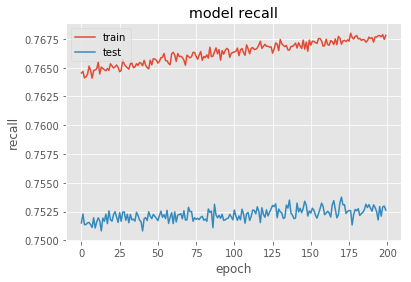

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

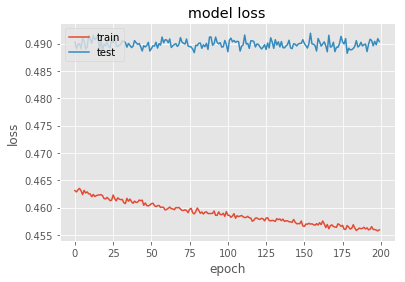

In [46]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()